In [2]:
from omegaconf import OmegaConf
from pytorch_lightning import Trainer
from dataloaders.coco17_loader import COCO17Loader
from sgm.util import instantiate_from_config
import torch
from pytorch_lightning.loggers import WandbLogger
import wandb
import pytorch_lightning as L
from dataloaders.imagenet_loader import ImageNetLatentLoader
from modules.models.decoding.openai_decoder import DiffusionDecoder
from modules.diffusion import DiffusionEngine
import time

device = "cuda"
torch.set_float32_matmul_precision("medium")

In [3]:

model_config_original = OmegaConf.load("configs/models/consistency_diffusion_decoder_ema.yaml")
# diffusion_decoder = instantiate_from_config(model_config_original.model)
diffusion_decoder = DiffusionEngine.load_from_checkpoint(
    "diffusion_models_sdxl_cdd/femtjxre/checkpoints/epoch=0-step=745.ckpt",
    network_config=model_config_original.model.params.network_config,
    denoiser_config=model_config_original.model.params.denoiser_config,
    conditioner_config=model_config_original.model.params.conditioner_config,
    first_stage_config=model_config_original.model.params.first_stage_config,
    loss_fn_config=model_config_original.model.params.loss_fn_config,
    sampler_config=model_config_original.model.params.sampler_config,
).cpu()
# diffusion_decoder.learning_rate = model_config_original.model.base_learning_rate


Initialized embedder #0: IdentityEncoder with 0 params. Trainable: True
Keeping EMAs of 2.


In [4]:
diffusion_decoder.model_ema.decay

tensor(0.9999)

In [ ]:

# loss_fn = instantiate_from_config(model_config.model.params.loss_fn_config)
# diffusion_decoder.loss_fn = loss_fn


# model_config = OmegaConf.load("configs/models/consistency_diffusion_decoder_ema.yaml")
# diffusion_decoder = instantiate_from_config(model_config.model)
# # Load replicated model
# # diffusion_decoder.model.diffusion_model = DiffusionDecoder(320)
# # diffusion_decoder.model.diffusion_model.load_state_dict(torch.load("cdd_custom.pt"))
# # diffusion_decoder.model.diffusion_model = diffusion_decoder.model.diffusion_model.cuda()
# diffusion_decoder.learning_rate = model_config.model.base_learning_rate


# dataset = ImageNetLatentLoader(
#     batch_size, 5, val_frac=0.00035, test_frac=0.0, latents_subdir="latents_train_sdxl_128/",
#     dims=(128, 128), random_seed=2024, crop=True, shuffle=False)


In [ ]:
diffusion_decoder = diffusion_decoder.cpu()

In [ ]:
del diffusion_decoder


In [5]:

dataset = ImageNetLatentLoader(
    2, 5, val_frac=0.00035, test_frac=0.0, latents_subdir="latents_train_sdxl_128/",
    dims=(128, 128), random_seed=2024, crop=True, shuffle=False)


In [ ]:
dataset.val_dataloader()

In [6]:
imgs = None
latents = None
import tqdm
with torch.no_grad():
    for batch in dataset.val_dataloader():
        imgs = batch["jpg"]
        latents = batch["ltnt"]
        break

imgs.shape, latents.shape

(torch.Size([2, 3, 128, 128]), torch.Size([2, 4, 16, 16]))

In [7]:
imgs[0].min(), imgs[0].max()

(tensor(-0.9765), tensor(1.))

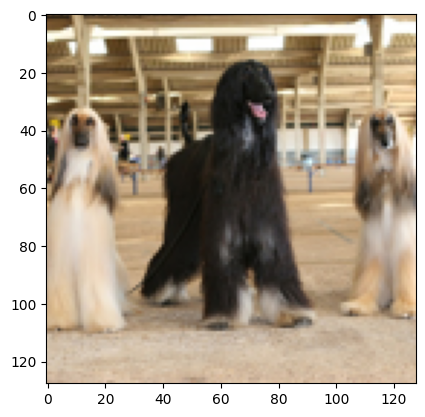

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow((imgs[0].cpu().float().numpy().transpose(1, 2, 0) + 1) / 2)


In [14]:
diffusion_decoder = diffusion_decoder.cuda()

In [9]:
diffusion_decoder.input_key = "ltnt"

In [16]:
diffusion_decoder.first_stage_model.decoder = None

In [17]:
sample = diffusion_decoder.generate(
    cond={"ltnt": latents.cuda()},
    batch_size=2,
    ucg_keys=["ltnt"],
    shape=(3, 128, 128)
)

tensor([[[[ 4.7961e+00,  6.9241e+00,  3.4921e+00,  ...,  1.0168e+01,
            4.8703e+00,  1.2604e+01],
          [ 2.5435e+00,  2.8850e+00,  7.2107e+00,  ...,  5.5965e+00,
            4.7998e+00,  2.3987e+00],
          [ 5.9086e-01,  2.0718e+00, -1.8897e-01,  ...,  3.1934e+00,
            7.6796e+00,  6.9357e+00],
          ...,
          [ 4.2005e+00,  4.9845e+00,  5.6854e+00,  ...,  2.4745e+00,
            5.0245e+00,  9.7932e-01],
          [ 9.0026e+00,  8.4690e+00,  5.5317e+00,  ...,  4.0590e+00,
            4.3362e+00,  5.2531e+00],
          [ 5.6399e+00,  4.5718e+00,  3.2690e+00,  ...,  4.5085e+00,
            4.3702e+00,  6.0223e+00]],

         [[-6.8200e+00,  1.2790e+00, -1.1986e+01,  ..., -7.8143e+00,
           -4.4266e+00, -2.8317e+00],
          [-6.6089e+00, -7.3260e+00, -2.0115e+00,  ...,  2.1473e+00,
           -5.5552e+00, -6.9292e+00],
          [-3.0117e-01, -2.4002e+00, -6.2576e+00,  ..., -1.6652e+00,
           -1.8679e-01, -9.1991e-01],
          ...,
     

/home/pg51242/Desktop/text2img-gen/text2img_dm/lib64/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


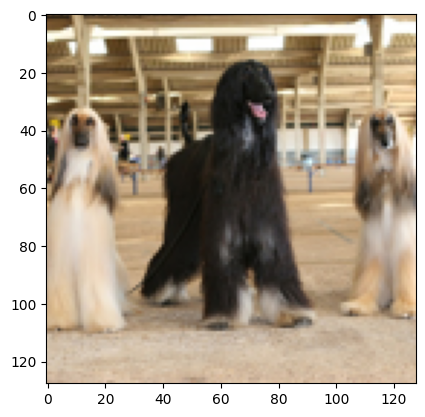

In [18]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow((imgs[0].cpu().float().numpy().transpose(1, 2, 0) + 1) / 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


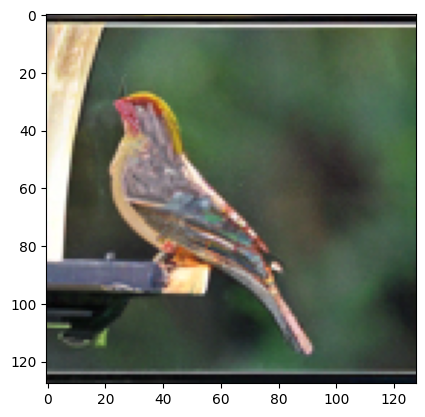

In [25]:
plt.imshow((sample[1].cpu().float().numpy().transpose(1, 2, 0) + 1) / 2)


In [22]:
with diffusion_decoder.ema_scope():
    sample_ema = diffusion_decoder.generate(
        cond={"ltnt": latents.cuda()},
        batch_size=2,
        ucg_keys=["ltnt"],
        shape=(3, 128, 128)
    )

tensor([[[[ 4.7961e+00,  6.9241e+00,  3.4921e+00,  ...,  1.0168e+01,
            4.8703e+00,  1.2604e+01],
          [ 2.5435e+00,  2.8850e+00,  7.2107e+00,  ...,  5.5965e+00,
            4.7998e+00,  2.3987e+00],
          [ 5.9086e-01,  2.0718e+00, -1.8897e-01,  ...,  3.1934e+00,
            7.6796e+00,  6.9357e+00],
          ...,
          [ 4.2005e+00,  4.9845e+00,  5.6854e+00,  ...,  2.4745e+00,
            5.0245e+00,  9.7932e-01],
          [ 9.0026e+00,  8.4690e+00,  5.5317e+00,  ...,  4.0590e+00,
            4.3362e+00,  5.2531e+00],
          [ 5.6399e+00,  4.5718e+00,  3.2690e+00,  ...,  4.5085e+00,
            4.3702e+00,  6.0223e+00]],

         [[-6.8200e+00,  1.2790e+00, -1.1986e+01,  ..., -7.8143e+00,
           -4.4266e+00, -2.8317e+00],
          [-6.6089e+00, -7.3260e+00, -2.0115e+00,  ...,  2.1473e+00,
           -5.5552e+00, -6.9292e+00],
          [-3.0117e-01, -2.4002e+00, -6.2576e+00,  ..., -1.6652e+00,
           -1.8679e-01, -9.1991e-01],
          ...,
     

/home/pg51242/Desktop/text2img-gen/text2img_dm/lib64/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


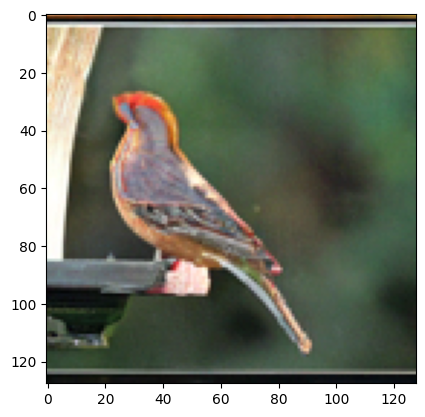

In [24]:
plt.imshow((sample_ema[1].cpu().float().numpy().transpose(1, 2, 0) + 1) / 2)


In [26]:
diffusion_decoder.scale_factor = 1
sample_nosf = diffusion_decoder.generate(
    cond={"ltnt": latents.cuda()},
    batch_size=2,
    ucg_keys=["ltnt"],
    shape=(3, 128, 128)
)

tensor([[[[ 4.7961e+00,  6.9241e+00,  3.4921e+00,  ...,  1.0168e+01,
            4.8703e+00,  1.2604e+01],
          [ 2.5435e+00,  2.8850e+00,  7.2107e+00,  ...,  5.5965e+00,
            4.7998e+00,  2.3987e+00],
          [ 5.9086e-01,  2.0718e+00, -1.8897e-01,  ...,  3.1934e+00,
            7.6796e+00,  6.9357e+00],
          ...,
          [ 4.2005e+00,  4.9845e+00,  5.6854e+00,  ...,  2.4745e+00,
            5.0245e+00,  9.7932e-01],
          [ 9.0026e+00,  8.4690e+00,  5.5317e+00,  ...,  4.0590e+00,
            4.3362e+00,  5.2531e+00],
          [ 5.6399e+00,  4.5718e+00,  3.2690e+00,  ...,  4.5085e+00,
            4.3702e+00,  6.0223e+00]],

         [[-6.8200e+00,  1.2790e+00, -1.1986e+01,  ..., -7.8143e+00,
           -4.4266e+00, -2.8317e+00],
          [-6.6089e+00, -7.3260e+00, -2.0115e+00,  ...,  2.1473e+00,
           -5.5552e+00, -6.9292e+00],
          [-3.0117e-01, -2.4002e+00, -6.2576e+00,  ..., -1.6652e+00,
           -1.8679e-01, -9.1991e-01],
          ...,
     

/home/pg51242/Desktop/text2img-gen/text2img_dm/lib64/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [27]:
sample_nosf_ema = diffusion_decoder.generate(
    cond={"ltnt": latents.cuda()},
    batch_size=2,
    ucg_keys=["ltnt"],
    shape=(3, 128, 128)
)

tensor([[[[ 4.7961e+00,  6.9241e+00,  3.4921e+00,  ...,  1.0168e+01,
            4.8703e+00,  1.2604e+01],
          [ 2.5435e+00,  2.8850e+00,  7.2107e+00,  ...,  5.5965e+00,
            4.7998e+00,  2.3987e+00],
          [ 5.9086e-01,  2.0718e+00, -1.8897e-01,  ...,  3.1934e+00,
            7.6796e+00,  6.9357e+00],
          ...,
          [ 4.2005e+00,  4.9845e+00,  5.6854e+00,  ...,  2.4745e+00,
            5.0245e+00,  9.7932e-01],
          [ 9.0026e+00,  8.4690e+00,  5.5317e+00,  ...,  4.0590e+00,
            4.3362e+00,  5.2531e+00],
          [ 5.6399e+00,  4.5718e+00,  3.2690e+00,  ...,  4.5085e+00,
            4.3702e+00,  6.0223e+00]],

         [[-6.8200e+00,  1.2790e+00, -1.1986e+01,  ..., -7.8143e+00,
           -4.4266e+00, -2.8317e+00],
          [-6.6089e+00, -7.3260e+00, -2.0115e+00,  ...,  2.1473e+00,
           -5.5552e+00, -6.9292e+00],
          [-3.0117e-01, -2.4002e+00, -6.2576e+00,  ..., -1.6652e+00,
           -1.8679e-01, -9.1991e-01],
          ...,
     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


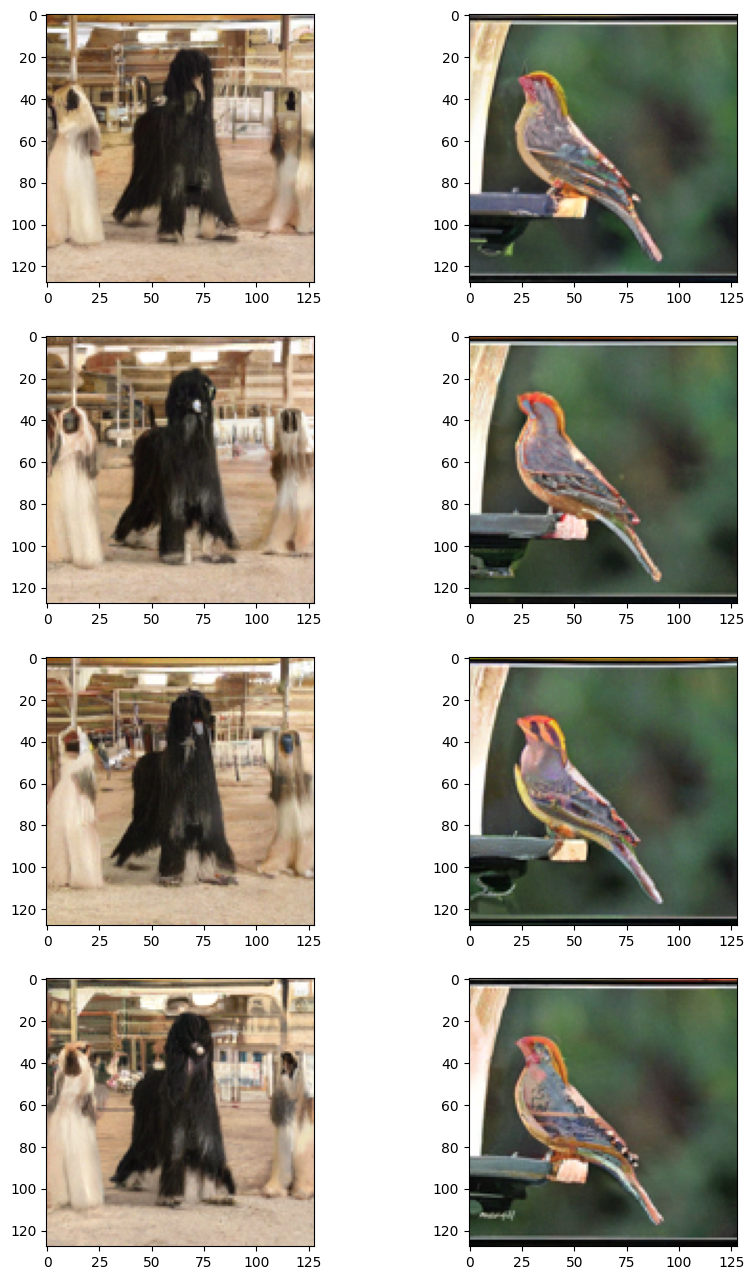

In [30]:
fig = plt.figure(figsize = (10,16))

ax1 = fig.add_subplot(4, 2, (0*2) + 1)
plt.imshow((sample[0].cpu().float().numpy().transpose(1, 2, 0) + 1) / 2)
ax2 = fig.add_subplot(4, 2, (0*2) + 2)
plt.imshow((sample[1].cpu().float().numpy().transpose(1, 2, 0) + 1) / 2)

ax3 = fig.add_subplot(4, 2, (1*2) + 1)
plt.imshow((sample_ema[0].cpu().float().numpy().transpose(1, 2, 0) + 1) / 2)
ax4 = fig.add_subplot(4, 2, (1*2) + 2)
plt.imshow((sample_ema[1].cpu().float().numpy().transpose(1, 2, 0) + 1) / 2)

ax5 = fig.add_subplot(4, 2, (2*2) + 1)
plt.imshow((sample_nosf[0].cpu().float().numpy().transpose(1, 2, 0) + 1) / 2)
ax6 = fig.add_subplot(4, 2, (2*2) + 2)
plt.imshow((sample_nosf[1].cpu().float().numpy().transpose(1, 2, 0) + 1) / 2)

ax7 = fig.add_subplot(4, 2, (3*2) + 1)
plt.imshow((sample_nosf_ema[0].cpu().float().numpy().transpose(1, 2, 0) + 1) / 2)
ax8 = fig.add_subplot(4, 2, (3*2) + 2)
plt.imshow((sample_nosf_ema[1].cpu().float().numpy().transpose(1, 2, 0) + 1) / 2)


In [35]:
((imgs-sample.cpu())**2).mean(), ((imgs-sample_ema.cpu())**2).mean(), ((imgs-sample_nosf.cpu())**2).mean(), ((imgs-sample_nosf_ema.cpu())**2).mean()

(tensor(0.0449), tensor(0.0445), tensor(0.0425), tensor(0.0482))

In [36]:
latents[0].min(), latents[0].max()

(tensor(-16.2061), tensor(18.4305))

In [38]:
(latents[0] * 0.13025).min()

tensor(-2.1109)